# Sampler statistics

When checking for convergence or when debugging a badly behaving
sampler, it is often helpful to take a closer look at what the
sampler is doing. For this purpose some samplers export
statistics for each generated sample.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import xarray as xr

%matplotlib inline

print(f"Runing on PyMC3 v{pm.__version__}")

Runing on PyMC3 v3.11.2


In [2]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

As a minimal example we sample from a standard normal distribution:

In [3]:
model = pm.Model()
with model:
    mu1 = pm.Normal("mu1", mu=0, sigma=1, shape=10)

In [4]:
with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000, init=None, step=step, cores=2, return_inferencedata=True)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu1]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 10 seconds.


NUTS provides the following statistics:

In [5]:
trace.sample_stats

<xarray.Dataset>
Dimensions:             (chain: 2, draw: 2000)
Coordinates:
  * chain               (chain) int64 0 1
  * draw                (draw) int64 0 1 2 3 4 5 ... 1995 1996 1997 1998 1999
Data variables: (12/13)
    tree_depth          (chain, draw) int64 2 2 2 2 2 2 2 2 ... 2 2 2 2 3 2 2 2
    max_energy_error    (chain, draw) float64 1.095 -0.8137 ... -1.16 0.9584
    perf_counter_diff   (chain, draw) float64 0.0004437 0.0004427 ... 0.000403
    diverging           (chain, draw) bool False False False ... False False
    perf_counter_start  (chain, draw) float64 6.514 6.515 6.515 ... 9.144 9.145
    lp                  (chain, draw) float64 -17.36 -13.35 ... -11.35 -15.93
    ...                  ...
    acceptance_rate     (chain, draw) float64 0.7963 1.0 0.6071 ... 0.9773 0.41
    step_size_bar       (chain, draw) float64 0.9586 0.9586 ... 0.9527 0.9527
    step_size           (chain, draw) float64 1.21 1.21 1.21 ... 1.327 1.327
    n_steps             (chain, draw) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
    energy_error        (chain, draw) float64 0.5284 -0.7795 ... -1.16 0.9584
    energy              (chain, draw) float64 23.28 19.36 21.68 ... 18.12 18.48
Attributes:
    created_at:                 2021-04-02T20:30:30.207447
    arviz_version:              0.11.2
    inference_library:          pymc3
    inference_library_version:  3.11.2
    sampling_time:              10.13068675994873
    tuning_steps:               1000

[Arviz](https://arviz-devs.github.io/arviz/schema/schema.html#sample-stats) follows the following Name Convention for sample_stats variables:

- `lp`: The joint log posterior density for the model (up to an additive constant).

- `acceptance_rate`: The average acceptance probabilities of all possible samples in the proposed tree.

- `step_size`: The current integration step size.

- `step_size_nom`: The nominal integration step size. The `step_size` may differ from this, for example if the step size is jittered. Should only be present if `step_size` is also present and it varies between samples (i.e. step size is jittered).

- `tree_depth`: The number of tree doublings in the balanced binary tree.

- `n_steps`: The number of leapfrog steps computed. It is related to `tree_depth` with `n_steps <= 2^tree_dept`.

- `diverging`: (boolean) Indicates the presence of leapfrog transitions with large energy deviation from starting and subsequent termination of the trajectory. “large” is defined as `max_energy_error` going over a threshold.

- `energy`: The value of the Hamiltonian energy for the accepted proposal (up to an additive constant).

- `energy_error`: The difference in the Hamiltonian energy between the initial point and the accepted proposal.

- `max_energy_error`: The maximum absolute difference in Hamiltonian energy between the initial point and all possible samples in the proposed tree.

- `int_time`: The total integration time (static HMC sampler)



If the name of the statistic does not clash with the name of one of the variables, we can use indexing to get the values. The values for the chains will be concatenated.

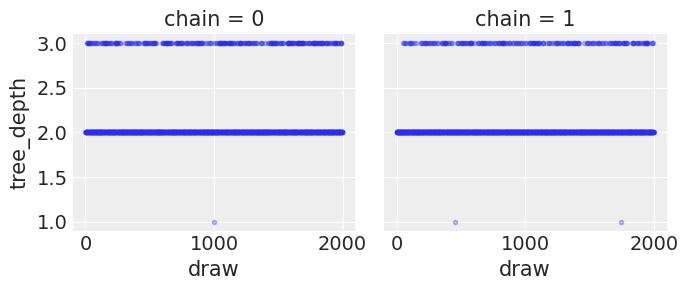

In [6]:
trace.sample_stats["tree_depth"].plot(col="chain", ls="none", marker=".", alpha=0.3);

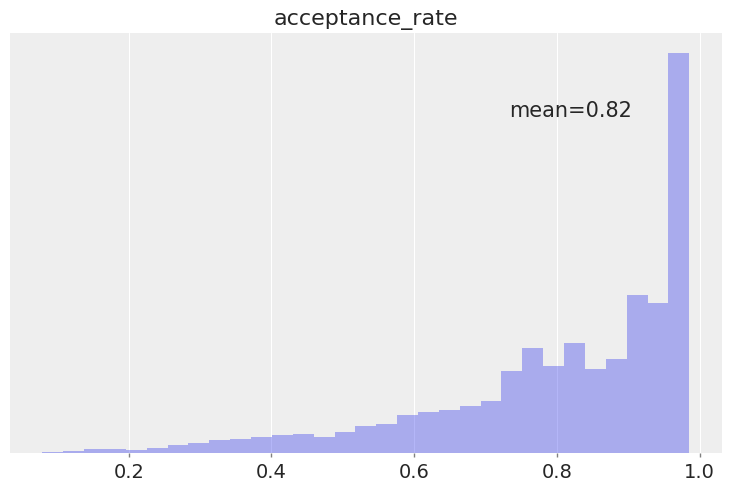

In [7]:
az.plot_posterior(
    trace, group="sample_stats", var_names="acceptance_rate", hdi_prob="hide", kind="hist"
);

We check if there are any divergences, if yes, how many?

In [8]:
trace.sample_stats["diverging"].sum()

<xarray.DataArray 'diverging' ()>
array(0)

In this case no divergences are found. If there are any, check [this notebook](https://github.com/pymc-devs/pymc-examples/blob/main/examples/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.ipynb) for  information on handling divergences.

It is often useful to compare the overall distribution of the
energy levels with the change of energy between successive samples.
Ideally, they should be very similar:

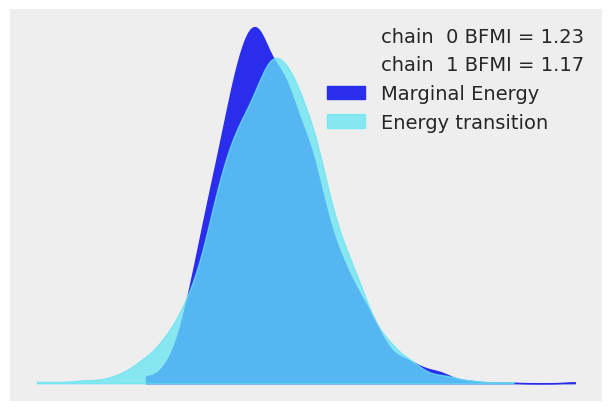

In [9]:
az.plot_energy(trace, figsize=(6, 4));

If the overall distribution of energy levels has longer tails, the efficiency of the sampler will deteriorate quickly.

## Multiple samplers

If multiple samplers are used for the same model (e.g. for continuous and discrete variables), the exported values are merged or stacked along a new axis.

Note that for the `model_logp` sampler statistic, only the last column (i.e. `trace.get_sampler_stat('model_logp')[-1]`) will be the overall model logp.

In [10]:
coords = {"step": ["BinaryMetropolis", "Metropolis"]}
dims = {"accept": ["step"]}

with pm.Model(coords=coords) as model:
    mu1 = pm.Bernoulli("mu1", p=0.8)
    mu2 = pm.Normal("mu2", mu=0, sigma=1, shape=10)
    step1 = pm.BinaryMetropolis([mu1])
    step2 = pm.Metropolis([mu2])
    trace = pm.sample(
        10000,
        init=None,
        step=[step1, step2],
        cores=2,
        tune=1000,
        return_inferencedata=True,
        idata_kwargs={"dims": dims, "coords": coords},
    )

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>BinaryMetropolis: [mu1]
>Metropolis: [mu2]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 12 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [11]:
list(trace.sample_stats.data_vars)

['accepted', 'accept', 'scaling', 'p_jump']

Both samplers export `accept`, so we get one acceptance probability for each sampler:

In [12]:
trace.sample_stats["accept"]

<xarray.DataArray 'accept' (chain: 2, draw: 10000, accept_dim_0: 2)>
array([[[1.00000000e+00, 4.81947076e-02],
        [2.50000000e-01, 2.56576697e-01],
        [1.00000000e+00, 6.04572017e-02],
        ...,
        [1.00000000e+00, 1.21193314e-02],
        [2.50000000e-01, 7.33432666e-02],
        [2.50000000e-01, 5.00810348e-03]],

       [[4.00000000e+00, 1.24853200e+00],
        [2.50000000e-01, 3.64256046e-01],
        [1.00000000e+00, 2.34105716e-04],
        ...,
        [1.00000000e+00, 3.60262141e+00],
        [2.50000000e-01, 3.22903087e-01],
        [2.50000000e-01, 1.45096507e+00]]])
Coordinates:
  * chain         (chain) int64 0 1
  * draw          (draw) int64 0 1 2 3 4 5 6 ... 9994 9995 9996 9997 9998 9999
  * accept_dim_0  (accept_dim_0) int64 0 1

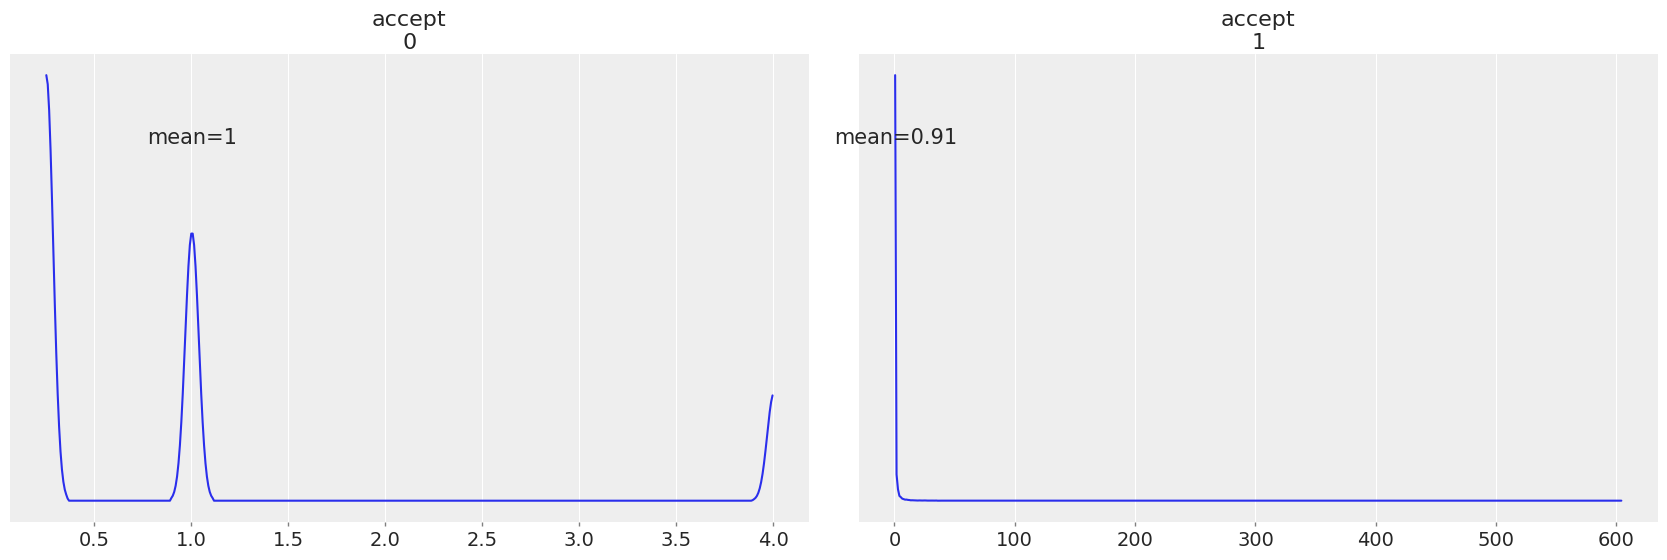

In [13]:
az.plot_posterior(trace, group="sample_stats", var_names="accept", hdi_prob="hide", kind="kde");

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Apr 03 2021

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

pymc3     : 3.11.2
numpy     : 1.20.1
xarray    : 0.17.0
pandas    : 1.2.3
seaborn   : 0.11.1
matplotlib: 3.3.4
arviz     : 0.11.2

Watermark: 2.2.0

